In [1164]:
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
from time import time


In [1108]:
X = np.linspace(0,2,10)[:,None]
Xlocs = X.copy()
X = np.c_[X,np.zeros(X.shape[0])]
X = np.r_[X,X]
#X[:int(len(X)/2),0]*=2
X[int(len(X)/2):,1]=1

y = 10*(1+np.cos(Xlocs/2))
X = tf.Variable(X,dtype=tf.float32)
Z = np.linspace(0,2,5)[:,None]
Z = np.r_[Z,Z]
Z = np.c_[Z,np.zeros(Z.shape[0])]
Z[int(len(Z)/2):,1]=1
Z = tf.Variable(Z,dtype=tf.float32)
y = tf.Variable(y,dtype=tf.float32)
m = Z.shape[0]

In [1109]:
Z

<tf.Variable 'Variable:0' shape=(10, 2) dtype=float32, numpy=
array([[0. , 0. ],
       [0.5, 0. ],
       [1. , 0. ],
       [1.5, 0. ],
       [2. , 0. ],
       [0. , 1. ],
       [0.5, 1. ],
       [1. , 1. ],
       [1.5, 1. ],
       [2. , 1. ]], dtype=float32)>

In [1110]:
def newK(X1,X2):
    cov = np.zeros([X1.shape[0],X2.shape[0]])
    for i1,x1 in enumerate(X1.numpy()):
        for i2,x2 in enumerate(X2.numpy()):
            if x1[-1]==x2[-1]:
                cov[i1,i2]=0.01*tf.exp(-tf.math.reduce_sum(x1[:-1]-x2[:-1])**2/(2*1**2))
    return tf.Variable(cov,dtype=np.float32)

def K(X1,X2):
    return 10.0*tf.cast(tf.math.equal(X1[:,-1,None],X2[None,:,-1]),tf.float32)*tf.exp(-tf.math.reduce_sum(tf.subtract(X1[:,None],X2[None,:])**2/(2*2**2),2)) 
    #return tf.exp(-tf.math.reduce_sum(tf.subtract(X1[:,None],X2[None,:])**2/(2*5**2),2)) 


In [1111]:
with tf.GradientTape() as tape:
    a = K(Z,Z)
tape.gradient(a, [Z])

[<tf.Tensor: id=46034128, shape=(10, 2), dtype=float32, numpy=
 array([[ 1.856e+01,  0.000e+00],
        [ 1.007e+01,  0.000e+00],
        [ 4.768e-07,  0.000e+00],
        [-1.007e+01,  0.000e+00],
        [-1.856e+01,  0.000e+00],
        [ 1.856e+01,  0.000e+00],
        [ 1.007e+01,  0.000e+00],
        [ 4.768e-07,  0.000e+00],
        [-1.007e+01,  0.000e+00],
        [-1.856e+01,  0.000e+00]], dtype=float32)>]

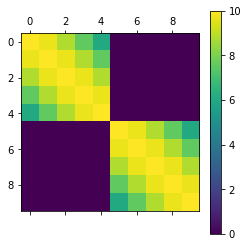

In [1112]:
plt.matshow(K(Z,Z))
plt.colorbar()

In [1133]:
#definition of q(u)
mu = tf.Variable(0*tf.random.normal([m]))#, name='mu')
scale = tf.Variable(1*tf.random.normal([m, m]))#, name='scale')

#parameters for p(u)
mu_u = tf.zeros([1,m])
cov_u = tf.Variable(K(Z,Z))

pu = tfd.MultivariateNormalFullCovariance(mu_u,cov_u+np.eye(cov_u.shape[0])*0.01)
invKzz = tf.linalg.inv(K(Z,Z)+np.eye(Z.shape[0],dtype=np.float32)*0.01)


In [1134]:
#dist = tfd.MultivariateNormalFullCovariance(tf.gather_nd(qf_mu,[[i,0],[i+20,0]]),tf.reshape(tf.gather_nd(qf_cov,[[i,i],[i,i+20],[i+20,i],[i+20,i+20]]),[2,2]))
#dist.sample(10)

In [1135]:
#def combine_sensor_latent(sens,lat):
#    return np.exp((sens+lat)/10) #tf.exp(sens)*lat

def combine_sensor_latent(sens,lat):
    return lat/(1+sens) #lat/tf.exp(sens)#(1+sens)

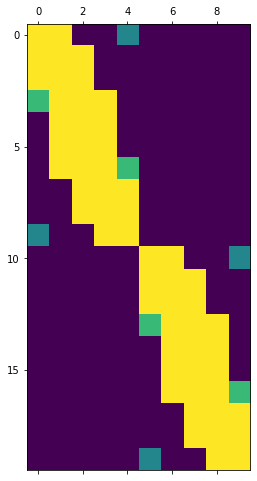

In [1136]:
plt.matshow(K(X,Z) @ invKzz)
plt.clim([0,0.1])

In [1166]:
st = time()
for it in range(100):
    with tf.GradientTape() as tape:
        qu = tfd.MultivariateNormalTriL(mu,scale)
        qf_mu = K(X,Z) @ invKzz @ mu[:,None]
        #need to solve in a numerically stable manner.
        #only need trace of this... TODO
        qf_cov = K(X,X) - K(X,Z) @ invKzz @ K(Z,X) + K(X,Z)@ invKzz @(scale@tf.transpose(scale))@ invKzz @ K(Z,X)
      
        ell = 0
        N = int(X.shape[0]/2)
        for i in range(N):
            dist = tfd.MultivariateNormalFullCovariance(tf.gather_nd(qf_mu,[[i,0],[i+N,0]]),tf.eye(2)*0.01+tf.reshape(tf.gather_nd(qf_cov,[[i,i],[i,i+N],[i+N,i],[i+N,i+N]]),[2,2]))
            samps = dist.sample(599)
            
            f = combine_sensor_latent(samps[:,1],samps[:,0]) #tf.exp(samps[:,1])*samps[:,0]
            #if i==0:
            if i<6:
                f =samps[:,0]
            #else:
            #    f = samps[:,1]
            
            lls = tfd.Normal(f,0.01).log_prob(y[i])
            ell+=tfp.stats.percentile(lls, 50.0)
            #ell+=tf.math.reduce_mean(lls)
           
        elbo_loss = -ell+tfd.kl_divergence(qu,pu)
       
    gradients = tape.gradient(elbo_loss, [mu, scale])
    optimizer.apply_gradients(zip(gradients, [mu, scale]))
    if it%5 == 0: print("%d %0.2f %0.4f %0.0f" % (it,time()-st,(time()-st)/(it+1),elbo_loss.numpy()))#,qf_mu[:,0].numpy(),mu.numpy())
                    

0 0.20 0.1992 34740
5 1.09 0.1815 35672
10 2.01 0.1829 32746


KeyboardInterrupt: 

In [1147]:
gradients

[<tf.Tensor: id=53422309, shape=(10,), dtype=float32, numpy=
 array([   2463.508,   -3057.719,   -4587.154,    -584.092,    7911.585,
         -28267.172,   36644.914,  103498.836,   70426.586, -130003.25 ],
       dtype=float32)>,
 <tf.Tensor: id=53422310, shape=(10, 10), dtype=float32, numpy=
 array([[-2.358e+02,  2.340e+02, -1.973e+02, -3.194e+02, -2.108e+02,
          2.183e+02, -4.076e+02, -5.245e+02,  5.160e+02,  1.782e+02],
        [ 4.783e+01, -3.751e+01,  7.807e+01,  1.762e+01, -6.460e+01,
         -4.511e+01, -7.758e+00,  2.347e+01,  3.597e+01,  4.636e+01],
        [ 1.409e+03, -1.283e+03,  1.090e+03,  6.693e+02, -9.182e+01,
         -5.305e+02,  1.639e+03,  2.581e+03, -1.933e+03, -1.040e+03],
        [ 2.239e+03, -2.274e+03,  1.915e+03,  6.299e+02, -5.163e+02,
         -5.735e+02,  2.675e+03,  4.352e+03, -3.145e+03, -1.922e+03],
        [ 1.514e+03, -1.568e+03,  1.354e+03, -8.606e+02, -1.460e+03,
          3.858e+02,  1.309e+03,  2.639e+03, -1.441e+03, -1.429e+03],
        [

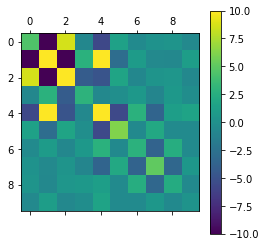

In [1167]:
plt.matshow(scale@tf.transpose(scale))
plt.colorbar()
plt.clim([-10,10])

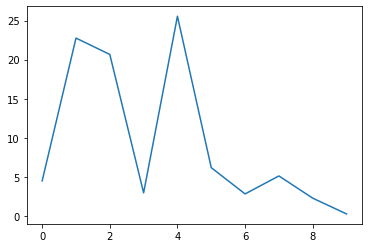

In [1168]:
plt.plot(np.diag(scale@tf.transpose(scale)))

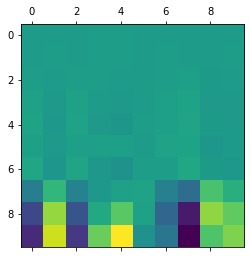

In [1169]:
plt.matshow(gradients[1].numpy())

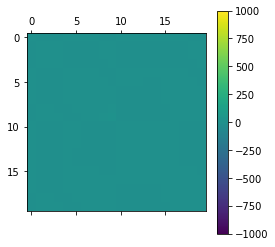

In [1170]:
plt.matshow(qf_cov)
plt.colorbar()
plt.clim([-1000,1000])

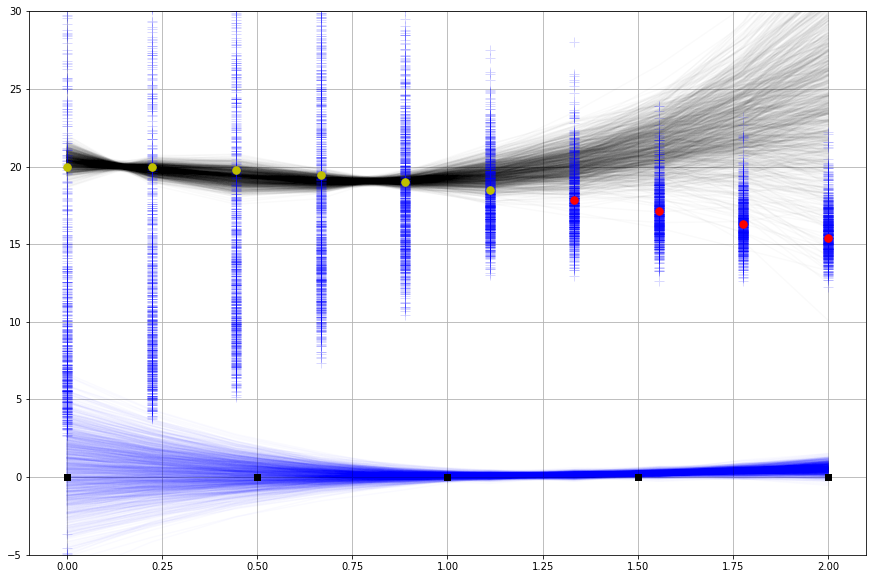

In [1173]:
plt.figure(figsize=[15,10])
qf = tfd.MultivariateNormalFullCovariance(qf_mu[:,0],qf_cov+np.eye(qf_cov.shape[0])*0.01)
samps = qf.sample([1000]).numpy()

Xn = X.numpy()
plt.plot(Xn[Xn[:,1]==0,0],samps[:,Xn[:,1]==0].T,'k-',alpha=0.02);
plt.plot(Xn[Xn[:,1]==1,0],(samps[:,Xn[:,1]==1].T),'b-',alpha=0.02);
plt.plot(Xn[Xn[:,1]==0,0],tf.transpose(combine_sensor_latent(samps[:,Xn[:,1]==1],samps[:,Xn[:,1]==0])),'b+',markersize=10,alpha=0.15);
#plt.plot(Xn[Xn[:,1]==0,0],samps[:,Xn[:,1]==1].T,'bx',alpha=0.05);
plt.ylim([-5,30])
plt.plot(Xlocs[:6,:],y.numpy()[:6],'.y',markersize=15)
plt.plot(Xlocs[6:,:],y.numpy()[6:],'.r',markersize=15)
#Xstar = np.linspace(-5,15,1000)[:,None]
#invKzz = tf.linalg.inv(K(Z,Z)+np.eye(Z.shape[0],dtype=np.float32)*0.01)

#mean = (K(Xstar,Z) @ invKzz @ mu.numpy()[:,None]).numpy()[:,0]
#cov = K(Xstar,Xstar) - K(Xstar,Z) @ np.linalg.inv(K(Z,Z)) @ K(Z,Xstar)
#stds = np.sqrt(np.diag(cov))

#plt.plot(Xstar,mean,'r-',lw=3);
#plt.plot(Xstar,mean+stds,'r-',lw=1);
#plt.plot(Xstar,mean-stds,'r-',lw=1);
plt.grid()
plt.plot(Z.numpy()[:,0],np.zeros_like(Z.numpy()),'ks')

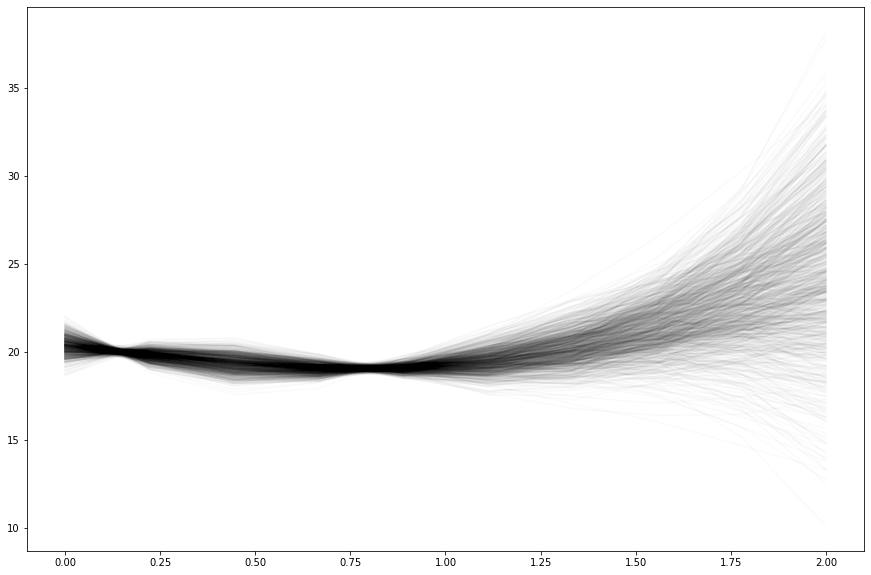

In [1174]:
plt.figure(figsize=[15,10])
#plt.plot(Xn[Xn[:,1]==0,0],(samps[:,Xn[:,1]==0]-np.mean(samps[:,Xn[:,1]==0],0)).T,'k-',alpha=0.1);
plt.plot(Xn[Xn[:,1]==0,0],(samps[:,Xn[:,1]==0]).T,'k-',alpha=0.02);
#plt.ylim([-300,300])

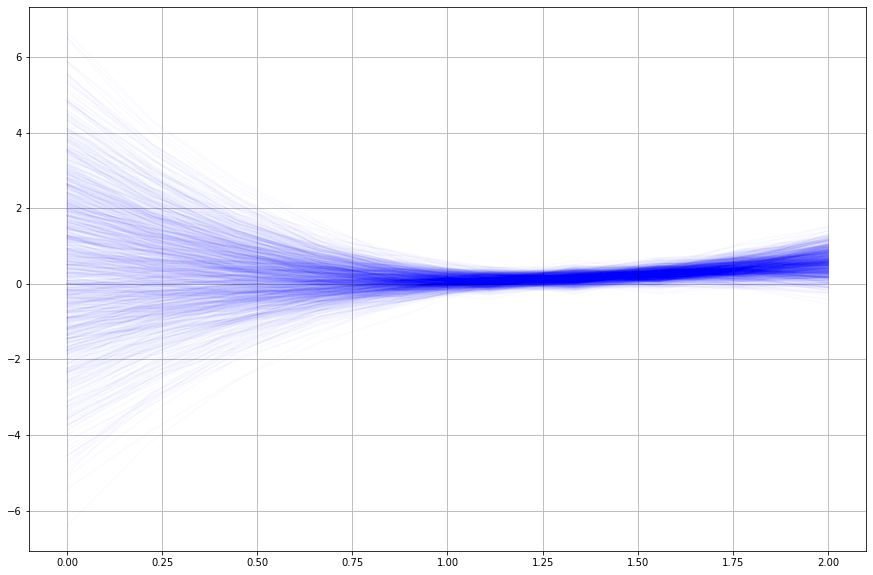

In [1175]:
plt.figure(figsize=[15,10])
#plt.plot(Xn[Xn[:,1]==0,0],(samps[:,Xn[:,1]==0]-np.mean(samps[:,Xn[:,1]==0],0)).T,'k-',alpha=0.1);
plt.plot(Xn[Xn[:,1]==1,0],(samps[:,Xn[:,1]==1]).T,'b-',alpha=0.02);
#plt.ylim([-300,300])
plt.grid()

In [975]:
samps

array([[18.74 , 22.201, 23.597, ...,  1.245,  0.277, -0.374],
       [19.417, 21.249, 21.934, ...,  0.555, -1.546, -1.811],
       [21.154, 20.074, 18.273, ..., -1.08 ,  1.724, -1.53 ],
       ...,
       [18.633, 21.854, 21.673, ..., -0.476,  0.224, -2.379],
       [21.482, 19.616, 19.623, ...,  0.903,  0.1  , -1.198],
       [19.642, 18.009, 19.344, ..., -0.877,  0.707,  1.612]],
      dtype=float32)

In [977]:
samps.shape

(100, 20)

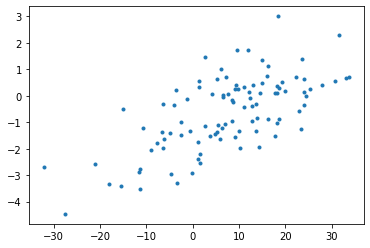

In [980]:
plt.plot(samps[:,8],samps[:,8+10],'.');

In [60]:
b

<tf.Tensor: id=47954, shape=(2, 2), dtype=float32, numpy=
array([[ 4.499, -0.731],
       [-0.731,  3.24 ]], dtype=float32)>

In [853]:
x = tf.Variable(tf.random.normal([2,2]))#, name='scale')
#x=tf.transpose(x)@x
with tf.GradientTape() as tape:
    y = x*2
tape.gradient(y,[x])

[<tf.Tensor: id=27553075, shape=(2, 2), dtype=float32, numpy=
 array([[2., 2.],
        [2., 2.]], dtype=float32)>]

In [922]:
def like(x,y):
    f = x/(1+y)
    #f = tf.where(tf.greater(f, 10), 10*tf.ones_like(f,dtype=np.float32), f)
    #f = tf.where(tf.less(f, -10), -10*tf.ones_like(f,dtype=np.float32), f)
    return f

X = np.linspace(-10,10,60)
Y = np.linspace(-10,10,60)
p = []
v = []
for i,x in enumerate(X):
    for j,y in enumerate(Y):
        p.append([x,y])
        v.append(tfd.Normal(tf.Variable(like(x,y),dtype=np.float32),0.1).log_prob(1))
p=np.array(p)
v=np.array(v)

In [932]:
a = tf.Variable(1*tf.random.normal([2]))#, name='mu')
b = tf.Variable(3*tf.random.normal([2,2]))#, name='scale')

[<tf.Tensor: id=30509788, shape=(2,), dtype=float32, numpy=array([-1.765,  1.836], dtype=float32)>, <tf.Tensor: id=30509847, shape=(2, 2), dtype=float32, numpy=
array([[ 0.809, -0.868],
       [ 0.795, -0.805]], dtype=float32)>] 
 [ 0.325 -0.585] 
 [[2.588 2.665]
 [3.391 3.29 ]]


/home/mike/anaconda3/lib/python3.6/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


(-10, 10)

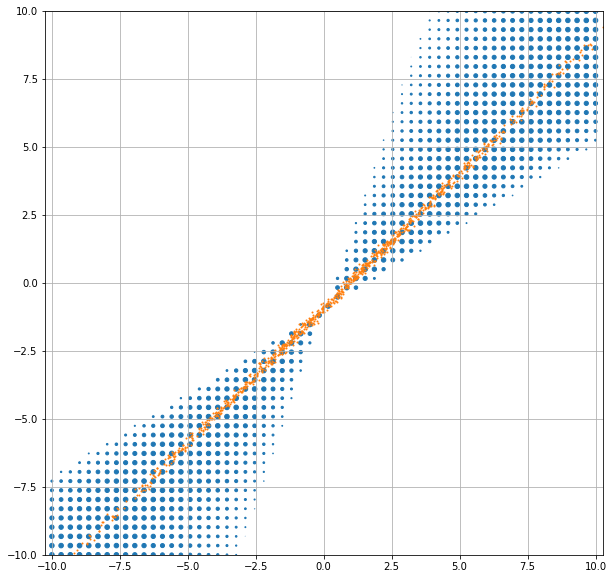

In [934]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
for it in range(100):
    with tf.GradientTape() as tape:
        try:
            dist = tfd.MultivariateNormalFullCovariance(a,tf.transpose(b)@b)
        except Exception:
            print("FAILED!")
            #b=b+tf.eye(2)*0.1
            break
        samps = dist.sample(10000)
        f = like(samps[:,0],samps[:,1])
        #f = samps[:,0]/tf.exp(samps[:,1])
        lls = tfd.Normal(f,0.1).log_prob(1)
        #ell=-tf.math.reduce_mean(lls)
        ell = -tfp.stats.percentile(lls, 50.0)
        
        ell=ell-tf.linalg.det(b)*0.01
        #ell = tf.math.reduce_mean(b)
    gradients = tape.gradient(ell, [a,b])
    optimizer.apply_gradients(zip(gradients, [a,b]))
    #b=b+gradients[1].numpy()
    #plt.hist(f,100,range=[-4,4]);
    #plt.grid()
print(gradients,'\n',a.numpy(),'\n',b.numpy())
dist = tfd.MultivariateNormalFullCovariance(a,tf.transpose(b)@b)
samps = dist.sample(1000)
plt.figure(figsize=[10,10])
plt.scatter(p[:,0],p[:,1],20+v)
plt.scatter(samps[:,0],samps[:,1],1);
plt.grid()
plt.axis('equal')
plt.xlim([-10,10])
plt.ylim([-10,10])

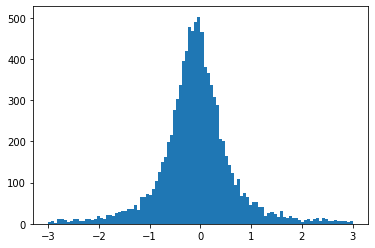

In [665]:
plt.hist(f,100,range=[-3,3]);

/home/mike/anaconda3/lib/python3.6/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


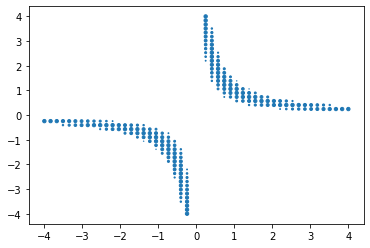

In [789]:
with tf.GradientTape() as tape:
    testmean = tf.Variable(0.1)
    samples = tfd.Normal(testmean,0.1).sample(3)
    result = tf.math.reduce_mean(samples)
gradients = tape.gradient(result,)
#.log_prob(1))

<tf.Tensor: id=12693132, shape=(3,), dtype=float32, numpy=array([-0.029,  0.146,  0.191], dtype=float32)>